In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('stocks.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

Epoch 1/20
55/55 - 39s - loss: 0.0069 - 39s/epoch - 702ms/step
Epoch 2/20
55/55 - 12s - loss: 0.0021 - 12s/epoch - 222ms/step
Epoch 3/20
55/55 - 12s - loss: 0.0014 - 12s/epoch - 221ms/step
Epoch 4/20
55/55 - 12s - loss: 0.0017 - 12s/epoch - 215ms/step
Epoch 5/20
55/55 - 11s - loss: 0.0014 - 11s/epoch - 198ms/step
Epoch 6/20
55/55 - 12s - loss: 0.0014 - 12s/epoch - 225ms/step
Epoch 7/20
55/55 - 13s - loss: 0.0014 - 13s/epoch - 231ms/step
Epoch 8/20
55/55 - 13s - loss: 0.0012 - 13s/epoch - 231ms/step
Epoch 9/20
55/55 - 12s - loss: 0.0013 - 12s/epoch - 225ms/step
Epoch 10/20
55/55 - 18s - loss: 9.1703e-04 - 18s/epoch - 323ms/step
Epoch 11/20
55/55 - 20s - loss: 0.0011 - 20s/epoch - 366ms/step
Epoch 12/20
55/55 - 14s - loss: 0.0010 - 14s/epoch - 252ms/step
Epoch 13/20
55/55 - 12s - loss: 9.3779e-04 - 12s/epoch - 221ms/step
Epoch 14/20
55/55 - 12s - loss: 0.0011 - 12s/epoch - 224ms/step
Epoch 15/20
55/55 - 12s - loss: 0.0010 - 12s/epoch - 223ms/step
Epoch 16/20
55/55 - 10s - loss: 0.0011 - 

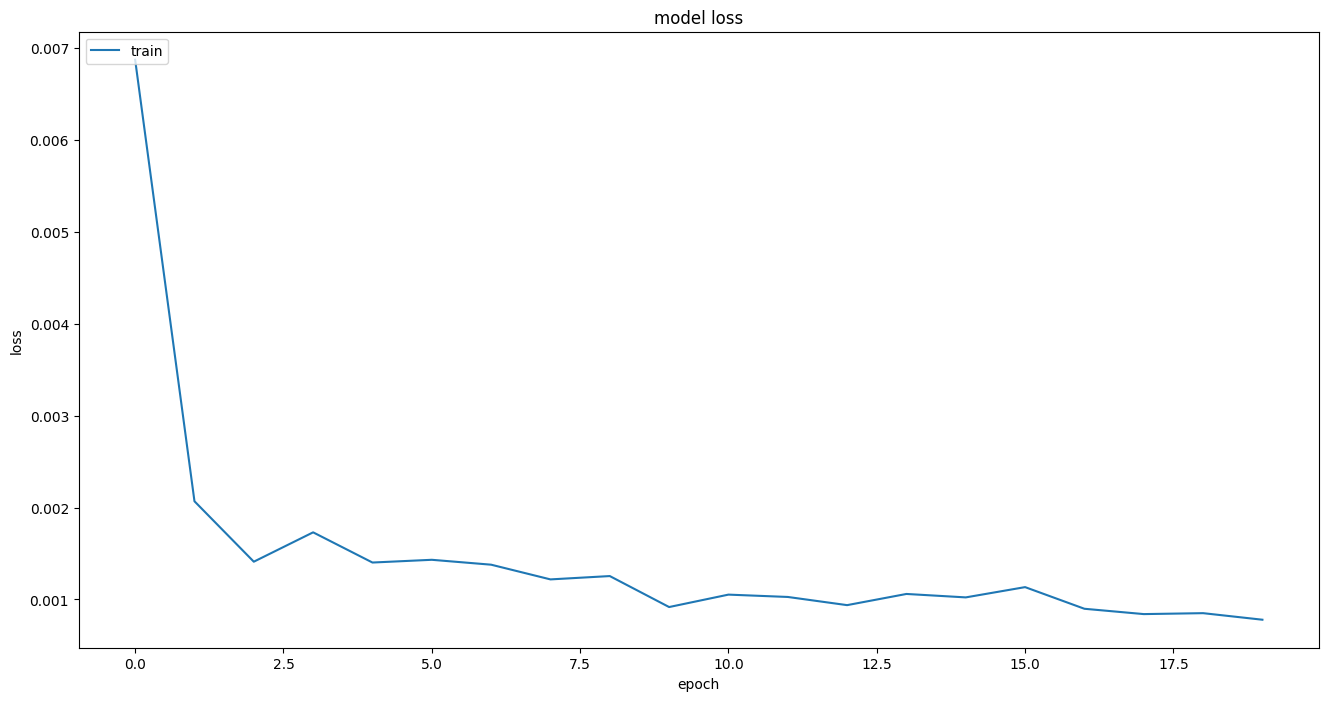

In [3]:
dec_2020 = '2020-12-31'
mask = (df['Date'] <= dec_2020)
data_20 = df.loc[mask]
mask = (df['Date'] > dec_2020)
data_23 = df.loc[mask]
training_set = data_20.iloc[:,4:5].values
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
X_train = []
y_train = []
for i in range(60, 1795):
    X_train.append(scaled_training_set[i-60:i,0])
    y_train.append(scaled_training_set[i,0])
X_train,y_train = np.array(X_train),np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #adding the batch_size axis
model = Sequential()

model.add(LSTM(units=100, return_sequences = True, input_shape =(X_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units=100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units =1))
model.compile(optimizer='adam',loss="mean_squared_error")
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose=2)
plt.figure(figsize = (16, 8))
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [5]:
testing_set = data_23.iloc[:,4:5]
y_test = testing_set.iloc[60:,0:].values
testing_set = testing_set.iloc[:,0:].values
scaled_testing_set = scaler.transform(testing_set)
scaled_testing_set.shape

(720, 1)

21/21 [==============================] - 3s 68ms/step


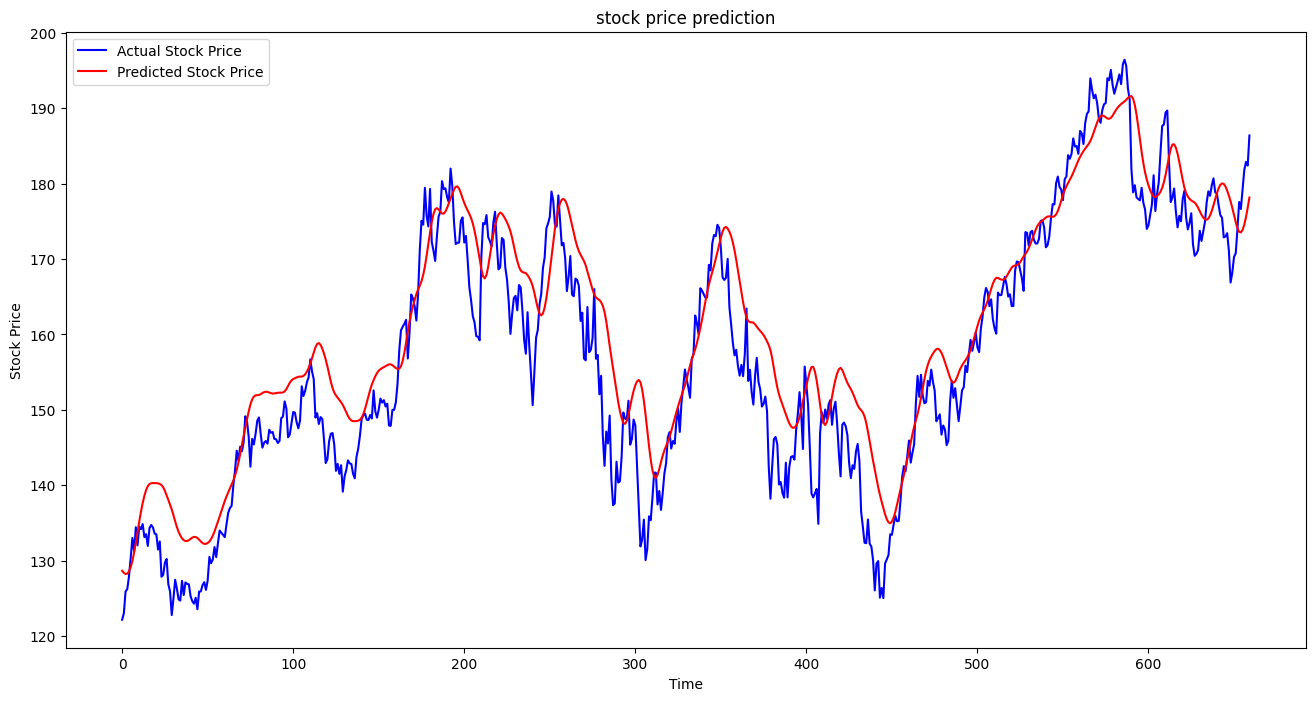

In [6]:
X_test = []

for i in range(60, 720):
    X_test.append(scaled_testing_set[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)) #adding the batch_size axis
y_pred = model.predict(X_test)
predicted_price = scaler.inverse_transform(y_pred)
plt.figure(figsize = (16, 8))

plt.plot(y_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
plt.title('stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()